# Notebook de test


## Importation des bibliothèques


In [4]:
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import matplotlib.pyplot as plt


import spacy
import random
import math
from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.ensemble import RandomForestRegressor

AttributeError: partially initialized module 'pandas' has no attribute 'core' (most likely due to a circular import)

## Fonctions utiles

In [ ]:
def progress_bar(iteration, total, prefix='', suffix='', decimals=1, length=50, fill='█'):
    """Fonction d'affichage de progress bar, récupérée sur le Notebook du TD1 de Data Sciences de Myriam Tami
    """
    percent = ("{0:." + str(decimals) + "f}").format(100 * (iteration / float(total)))
    filled_length = int(length * iteration // total)
    bar = fill * filled_length + '-' * (length - filled_length)
    print(f'\r{prefix} |{bar}| {percent}% {suffix}', end='\r')
    # Print New Line on Complete
    if iteration == total:
        print()
                
def raw_to_tokens(raw_string, spacy_nlp):
        # Write code for lower-casing
    string = raw_string.lower()

    # Write code to normalize the accents
    string = normalize_accent(string)

    # Write code to tokenize
    spacy_tokens = spacy_nlp(string)
    

    # Write code to remove punctuation tokens and create string tokens
    string_tokens = [token.orth_ for token in spacy_tokens if not token.is_punct if not token.is_stop]
    # Write code to join the tokens back into a single string
    clean_string = " ".join(string_tokens)

    return clean_string


def normalize_accent(string):
    string = string.replace('á', 'a')
    string = string.replace('â', 'a')
    string = string.replace('à', 'a')
    
    string = string.replace('é', 'e')
    string = string.replace('è', 'e')
    string = string.replace('ê', 'e')
    string = string.replace('ë', 'e')

    string = string.replace('î', 'i')
    string = string.replace('ï', 'i')
    string = string.replace('n°','n')
    string = string.replace('ö', 'o')
    string = string.replace('ô', 'o')
    string = string.replace('ò', 'o')
    string = string.replace('ó', 'o')

    string = string.replace('ù', 'u')
    string = string.replace('û', 'u')
    string = string.replace('ü', 'u')

    string = string.replace('ç', 'c')

    return string

## Récupération des données

récupération du dico français

In [ ]:
spacy_nlp = spacy.load("fr_core_news_sm")

récupération des vecteurs x_data et y_data

In [ ]:
Reload = False
filename = "X_dt.mat"
subdata_ratio  = 1


if not Reload:
    X_data = scipy.io.loadmat('.\data\\' + filename)['data']
else:
    Xtrain_filename = ".\data\X_train_update.csv"   
    #pour le x_data (ici la designation, ie string)
    X_data = []
    raw_data = pd.read_csv(Xtrain_filename,index_col=0)
    design = raw_data['designation']
    #la boucle suivante prend bcp de temps
    for k in range(len(raw_data)//subdata_ratio):
        X_data.append(raw_to_tokens(design[k],spacy_nlp))
        progress_bar(k + 1,len(raw_data)//subdata_ratio, prefix='Preprocessing train:', suffix='Complété', length=50)
            
Y_train_filename = ".\data\Y_train_CVw08PX.csv"
#pour y_data (le product type id)
y_data = pd.read_csv(Y_train_filename,index_col=0)[:len(raw_data)//subdata_ratio] #récupération de la bonne colonne prdtypecode


Preprocessing train: |██████████████████████████████████████████████████| 100.0% Complété


Enregistrement de X_data en mémoire pour éviter de le reload à chaque fois

In [ ]:
mdic = {"data": X_data}
scipy.io.savemat('.\data\\' + filename,mdic)

On affiche le head du fichier

In [ ]:
raw_data[:5]

,designation,description,productid,imageid
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496
4,La Guerre Des Tuques,Luc a des id&eacute;es de grandeur. Il veut or...,278535884,1077757786


In [ ]:
y_data.head()
set(y_data['prdtypecode'].tolist())

{10,
 40,
 50,
 60,
 1140,
 1160,
 1180,
 1280,
 1281,
 1300,
 1301,
 1302,
 1320,
 1560,
 1920,
 1940,
 2060,
 2220,
 2280,
 2403,
 2462,
 2522,
 2582,
 2583,
 2585,
 2705,
 2905}

On affiche l'histogramme du type de produit sur tout le jeu de données

<AxesSubplot: xlabel='Count', ylabel='Code_produit'>

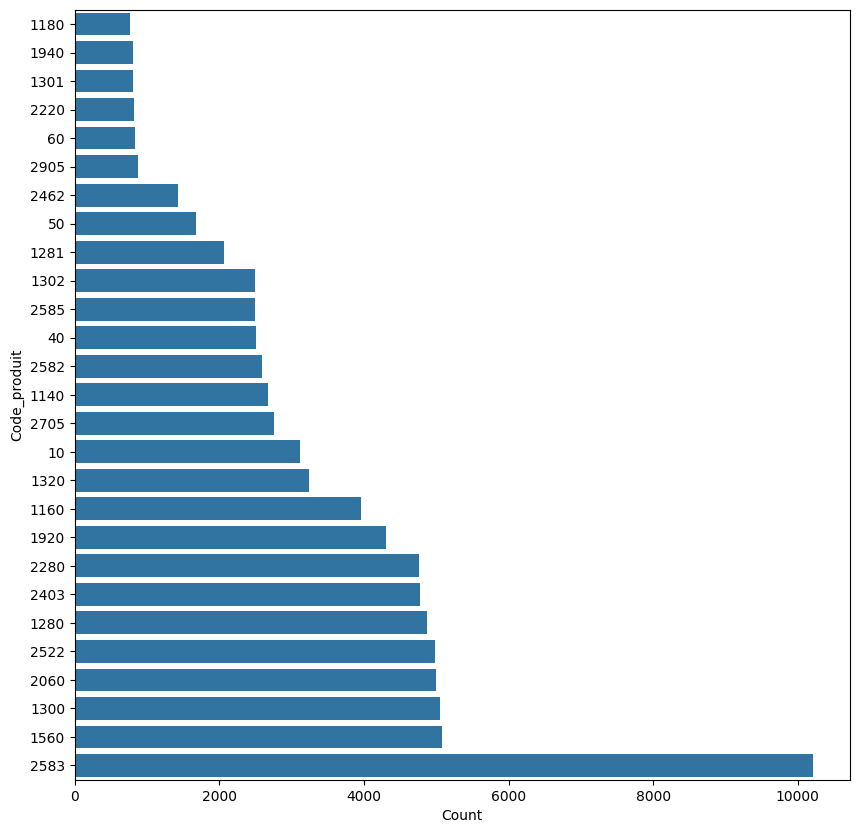

In [ ]:
hist_tab_y = pd.DataFrame(y_data.prdtypecode.value_counts()).reset_index()
hist_tab_y.columns = ['Code_produit', 'Count']
hist_y = hist_tab_y.sort_values("Count", ascending=True)
plt.figure(figsize=(10,10))
sns.barplot(x='Count', y='Code_produit', data=hist_y, orient='h', order=hist_y.Code_produit.tolist())


Une approche ici serait de repérer le vocabulaire endémique à chaque product type pour déterminer, en fonction de la désignation du produit, son type.

In [ ]:
tfidf = TfidfVectorizer()

# Write code to vectorize the sample text
X_tfidf_matrix = tfidf.fit_transform(X_data)

print("Shape of the TF-IDF Matrix:")
print(X_tfidf_matrix.shape)
print("TF-IDF Matrix:")



Shape of the TF-IDF Matrix:
(84916, 79882)
TF-IDF Matrix:


Split du jeu de données

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf_matrix, y_data, test_size=0.2, random_state=42)

# Méthode 1 : K-NN Classifier

In [ ]:
KNN_CL = False
if KNN_CL:
    params = {'n_neighbors':range(2,20)}
    n_folds = 10
    cv = KFold(n_splits=n_folds, shuffle=False)

    grid_search = GridSearchCV(
        estimator=KNeighborsClassifier(),
        param_grid=params,
        return_train_score=True,
        cv=cv,
        ).fit(X_train, y_train)


c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\neighbors\_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
grid_search.best_estimator_

KNeighborsClassifier(n_neighbors=19)

In [ ]:
BestKNN = KNeighborsClassifier(n_neighbors=19).fit(X_train,y_train)

y_predKNN = BestKNN.predict(X_test)

F1_score = f1_score(y_test,y_predKNN,average='macro')
print(F1_score)

0.44928423513714305


## Approche 2 : Deep Learning s1

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

X_tfidf = X_tfidf_matrix

# Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)

# Conversion des labels en une représentation catégorielle
y_categorical = to_categorical(y_encoded)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_categorical, test_size=0.2, random_state=42)

# Définir et compiler le modèle
input_dim = X_train.shape[1]
num_classes = y_categorical.shape[1]

model = Sequential()
model.add(Dense(1024, input_dim=input_dim, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Entraîner le modèle
history = model.fit(X_train.toarray(), y_train,
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test.toarray(), y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

y_pred_prob = model.predict(X_test.toarray())
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_test_true, y_pred))

# Visualiser les résultats
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


NameError: name 'X_tfidf_matrix' is not defined

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# Chargement des données
df = pd.read_csv('votre_fichier.csv')

# Extraction des features et des labels
X_data = df['designation']
y_data = df['identifiant_produit']

# Vectorisation TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(X_data)

# Encodage des labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y_data)

# Conversion des labels en une représentation catégorielle
y_categorical = to_categorical(y_encoded)

# Division des données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y_categorical, test_size=0.2, random_state=42)

# Définir et compiler le modèle
input_dim = X_train.shape[1]
num_classes = y_categorical.shape[1]

model = Sequential()
model.add(Dense(1024, input_dim=input_dim, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.001)

# Entraîner le modèle
history = model.fit(X_train.toarray(), y_train,
                    epochs=50, 
                    batch_size=32, 
                    validation_split=0.2,
                    callbacks=[early_stopping, reduce_lr])

# Évaluation du modèle
loss, accuracy = model.evaluate(X_test.toarray(), y_test)
print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

y_pred_prob = model.predict(X_test.toarray())
y_pred = np.argmax(y_pred_prob, axis=1)
y_test_true = np.argmax(y_test, axis=1)

print("Classification Report:\n", classification_report(y_test_true, y_pred))

# Visualiser les résultats
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()


c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\preprocessing\_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\chata\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Shape of y_categorical: (84916, 27)
Shape of X_train: (67932, 79882)
Shape of y_train: (67932, 27)
Shape of X_test: (16984, 79882)
Shape of y_test: (16984, 27)


MemoryError: Unable to allocate 40.4 GiB for an array with shape (67932, 79882) and data type float64

In [ ]:
print(f1_score(y_test_true,y_pred,average='macro'))

0.7018172599405393
